Neste primeiro bloco é realizada a importação das bibliotecas utilizadas no código.
- **matplotlib**: Utilizada para impressão dos gráficos dos resultados dos modelos
- **pandas**: Utilizada para manipulação do conjunto de dados
- **numpy**: Utilizada para operação matemáticas em cima do conjunto de dados
- **keras**: Utilizada para criação da rede neural
- **time**: Utilizada para marcar o tempo de execução do código

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.utils import plot_model
from keras import optimizers
from keras.utils import to_categorical
import time

Using TensorFlow backend.


Todas as configurações referentes a rede neural estão no bloco abaixo. Aqui é possível escolher qual conjunto de dados será utilizado, se o código deverá ou não remover as colunas correlacionadas, como será a divisão de dados entre treino e teste, a função de ativação utilizada e a taxa de aprendizado.

In [2]:
# Flag para remoção das colunas correlacionadas.
CLEAN_DATASET = True

# Flag para decisão de qual versão do dataset usar
DATASET_COMPLETO = False

# Caminho para o dataset
# Endereço para download: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# Backup: http://web.archive.org/web/*/http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
if DATASET_COMPLETO:
    DATASET_PATH = "D:/UNIFEI/TCC/kdd_dl/dataset/kddcup.data.corrected"   
    # Treino 98%, Validação 1%, Teste 1%
    # https://stackoverflow.com/a/13613316
    TRAIN_PERCENTAGE = 0.98
    VALIDATION_PERCENTAGE = 0.01
    TEST_PERCENTAGE = 0.01
else:
    DATASET_PATH = "D:/UNIFEI/TCC/kdd_dl/dataset/kddcup.data_10_percent_corrected"
    # Treino 80%, Validação 10%, Teste 10%
    TRAIN_PERCENTAGE = 0.8
    VALIDATION_PERCENTAGE = 0.1
    TEST_PERCENTAGE = 0.1
    
## Threshold de correlação para exclusão das colunas do dataset
CORRCOEF_THRESHOLD = 0.5

## Ignora os warnings de divisão por NaN
np.seterr(divide='ignore', invalid='ignore')


EPOCHS = 200 # Quantas vezes os dados serão corridos completamente
BATCH_SIZE = 1024 # Quantas linhas do dataset serão lidas por vez
SHUFFLE = True # Mistura os dados antes do treino
VERBOSE = 1 # 0 - Desativa os logs durante o treino, 1 - Imprime os logs durante o treino
LEARNING_RATE = 0.01 # Taxa de aprendizado
ACTIVATION_FN = "relu" # Função de ativação

O bloco abaixo realiza a leitura do conjunto de dados e cria um *dataframe* do *pandas* para manipulação mais fácil dos dados.

In [3]:
# Nome das colunas do dataset
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack",
]

#Leitura do dataset
dataset = pd.read_csv(
    DATASET_PATH,
    header = None,
    names = column_names)

Como o conjunto de dados possui valores léxicos, é necessário trocá-los por valores numéricos.

In [4]:
#Pega os valores  únicos das colunas que tem string
protocol_type_values = dataset.protocol_type.unique()
service_values = dataset.service.unique()
flag_values = dataset.flag.unique()
attack_values = dataset.attack.unique()

#Transforma as strings em números
protocol_type_dict = dict(zip(protocol_type_values, range(len(protocol_type_values))))
service_dict = dict(zip(service_values, range(len(service_values))))
flag_dict = dict(zip(flag_values, range(len(flag_values))))
attack_dict = dict(zip(attack_values, range(len(attack_values))))

In [5]:
#Substitui os valores no dataset que são string por números
dataset = dataset.replace(
    {"protocol_type": protocol_type_dict,
     "service": service_dict,
     "flag": flag_dict,
     "attack": attack_dict}
)

dataset = dataset.apply(pd.to_numeric)

Limpeza do dataset

In [6]:
#Apaga as colunas que tem correlação entre elas que seja maior que CORRCOEF_THRESHOLD
if CLEAN_DATASET:
    excluded = list()
    
    for index_1 in range(len(column_names)-1):
        for index_2 in range(len(column_names)-1):
            if column_names[index_1] not in excluded and column_names[index_2] not in excluded and index_1 != index_2:
                corrcoef = np.corrcoef(dataset[column_names[index_1]], dataset[column_names[index_2]])

                if abs(corrcoef[0][1]) > CORRCOEF_THRESHOLD:
                    excluded.append(column_names[index_2])
                
    dataset = dataset[dataset.columns.difference(excluded)]

Limpeza do dataset

In [7]:
#Separa os dados entre treino e teste
train, test = np.split(dataset.sample(frac=1), [int(TRAIN_PERCENTAGE * len(dataset))])

train_samples = train.drop(['attack'], axis=1)
train_labels = to_categorical(train[['attack']].to_numpy(), num_classes=len(attack_values))

test_samples = test.drop(['attack'], axis=1)
test_labels = to_categorical(test[['attack']].to_numpy(), num_classes=len(attack_values))

Modelo da rede neural

In [8]:
input_shape = (train_samples.shape[1],)

# Dense(15, activation=ACTIVATION_FN),
# Criação do modelo
model = Sequential([
    Dense(50, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(50, activation=ACTIVATION_FN),
    Dense(len(attack_values), activation='softmax'),
])

In [9]:
sgd = optimizers.SGD(lr=LEARNING_RATE)
model.compile(loss='mean_squared_error', optimizer=sgd)

model.compile(
    optimizer=sgd,
    loss='mean_squared_error', 
    metrics=['accuracy'],
)

Treino da rede neural

In [10]:
start_time = time.time()

# Treinamento do modelo
history = model.fit(
    x=train_samples, 
    y=train_labels, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    shuffle=SHUFFLE, #Mistura os dados
    verbose=VERBOSE,
    validation_split=VALIDATION_PERCENTAGE #Porcentagem dos dados de treino que serão usadas para validação
)

end_time = time.time()

Train on 355694 samples, validate on 39522 samples
Epoch 1/200
355694/355694 [==============================] - 3s 9us/step - loss: 0.0416 - accuracy: 0.0103 - val_loss: 0.0416 - val_accuracy: 0.1065
Epoch 2/200
355694/355694 [==============================] - 3s 9us/step - loss: 0.0416 - accuracy: 0.4373 - val_loss: 0.0415 - val_accuracy: 0.5663
Epoch 3/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0415 - accuracy: 0.5682 - val_loss: 0.0415 - val_accuracy: 0.5663
Epoch 4/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0415 - accuracy: 0.5682 - val_loss: 0.0415 - val_accuracy: 0.5663
Epoch 5/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0414 - accuracy: 0.5682 - val_loss: 0.0414 - val_accuracy: 0.5663
Epoch 6/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0414 - accuracy: 0.5682 - val_loss: 0.0414 - val_accuracy: 0.5663
Epoch 7/200
355694/355694 [============================

355694/355694 [==============================] - 3s 8us/step - loss: 0.0156 - accuracy: 0.7108 - val_loss: 0.0150 - val_accuracy: 0.7273
Epoch 56/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0141 - accuracy: 0.7382 - val_loss: 0.0135 - val_accuracy: 0.7372
Epoch 57/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0130 - accuracy: 0.7434 - val_loss: 0.0128 - val_accuracy: 0.7420
Epoch 58/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0125 - accuracy: 0.7462 - val_loss: 0.0125 - val_accuracy: 0.7428
Epoch 59/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0123 - accuracy: 0.7470 - val_loss: 0.0123 - val_accuracy: 0.7457
Epoch 60/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0121 - accuracy: 0.7494 - val_loss: 0.0122 - val_accuracy: 0.7459
Epoch 61/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0120 - accuracy: 0.7498 - val

355694/355694 [==============================] - 3s 8us/step - loss: 0.0039 - accuracy: 0.9647 - val_loss: 0.0030 - val_accuracy: 0.9669
Epoch 110/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0026 - accuracy: 0.9674 - val_loss: 0.0024 - val_accuracy: 0.9683
Epoch 111/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0023 - accuracy: 0.9682 - val_loss: 0.0022 - val_accuracy: 0.9690
Epoch 112/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0022 - accuracy: 0.9686 - val_loss: 0.0021 - val_accuracy: 0.9691
Epoch 113/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0021 - accuracy: 0.9689 - val_loss: 0.0021 - val_accuracy: 0.9694
Epoch 114/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0021 - accuracy: 0.9692 - val_loss: 0.0021 - val_accuracy: 0.9696
Epoch 115/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0020 - accuracy: 0.9693

355694/355694 [==============================] - 3s 8us/step - loss: 0.0020 - accuracy: 0.9696 - val_loss: 0.0020 - val_accuracy: 0.9701
Epoch 164/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0020 - accuracy: 0.9694 - val_loss: 0.0020 - val_accuracy: 0.9701
Epoch 165/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0020 - accuracy: 0.9697 - val_loss: 0.0019 - val_accuracy: 0.9703
Epoch 166/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0020 - accuracy: 0.9697 - val_loss: 0.0020 - val_accuracy: 0.9704
Epoch 167/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0020 - accuracy: 0.9697 - val_loss: 0.0019 - val_accuracy: 0.9701
Epoch 168/200
355694/355694 [==============================] - 3s 8us/step - loss: 0.0020 - accuracy: 0.9697 - val_loss: 0.0019 - val_accuracy: 0.9701
Epoch 169/200
355694/355694 [==============================] - 3s 7us/step - loss: 0.0020 - accuracy: 0.9697

Teste da rede neural

In [11]:
# Teste do modelo
h2 = model.evaluate(
    x=test_samples,
    y=test_labels,
    verbose=VERBOSE,
)
# plot_model(model, to_file='model.png' ,show_shapes=True, show_layer_names=True, expand_nested=True, dpi=200)

98805/98805 [==============================] - 6s 63us/step


Impressão dos resultados

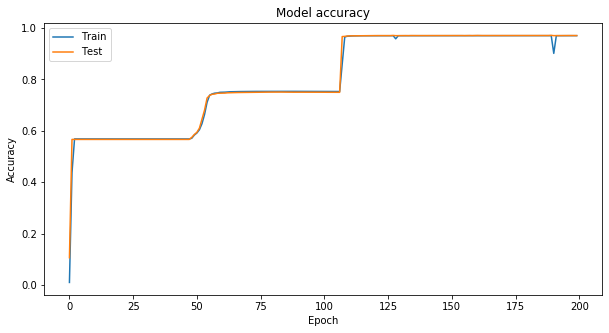

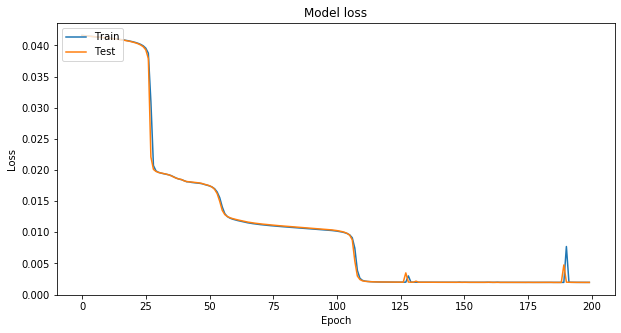

['loss', 'accuracy']
[0.002033613793379947, 0.9681898951530457]
{'CLEAN_DATASET': True, 'DATASET_COMPLETO': False, 'CORRCOEF_THRESHOLD': 0.5, 'BATCH_SIZE': 1024, 'EPOCHS': 200, 'SHUFFLE': True, 'VERBOSE': 1, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.01, 'ACTIVATION_FN': 'relu', 'TEMPO': 548.5128421783447}


In [12]:
# plot_model(model, to_file='model.png')

# Plot training & validation accuracy values
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print(model.metrics_names)
print(h2)

print({
"CLEAN_DATASET":CLEAN_DATASET,
"DATASET_COMPLETO":DATASET_COMPLETO,
"CORRCOEF_THRESHOLD":CORRCOEF_THRESHOLD,
"BATCH_SIZE":BATCH_SIZE,
"EPOCHS":EPOCHS,
"SHUFFLE":SHUFFLE,
"VERBOSE":VERBOSE,
"VALIDATION_SPLIT":VALIDATION_PERCENTAGE,
"LEARNING_RATE":LEARNING_RATE,
"ACTIVATION_FN":ACTIVATION_FN,
"TEMPO": end_time-start_time})

In [13]:
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# from keras import backend as K

# with a Sequential model
# get_3rd_layer_output = K.function([model.layers[0].input],
#                                   [model.layers[3].output])
# print(get_3rd_layer_output)

# print(model.layers[0].input)
# print(model.layers[0].output)

# print(model.layers[1].input)
# print(model.layers[1].output)

# print(model.layers[2].input)
# print(model.layers[2].output)

# print(model.layers[3].input)
# print(model.layers[3].output)

# from keras import backend as K

# input1 = model.input # input placeholder

# output1 = [layer.output for layer in model.layers]# all layer outputs

# fun = K.function([input1, K.learning_phase()],output1)# evaluation function

# # Testing

# t = np.random.random((41,))[np.newaxis,...]

# t = np.array([[0,1,19,9,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00]])

# layer_outputs = fun([t, 1])



# print(layer_outputs[0]) #printing the outputs of layers
# print(layer_outputs[1]) #printing the outputs of layers
# print(layer_outputs[2]) #printing the outputs of layers
# print(layer_outputs[3]) #printing the outputs of layers